# Audio Data Augmentation

In [6]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.1.0
2.1.0


## Preparation

In [7]:
from IPython.display import Audio

from torchaudio.utils import download_asset

# VIVOSDEV01_R002 TIẾNG CỌC CẠCH KHỰNG LẠI CỦA NHỮNG KHỚP SẮT
SAMPLE_WAV = "datasets/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R002.wav"
# SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")

SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

## Apply effects and filtering

In [8]:
# Load the data
waveform1, sample_rate = torchaudio.load(SAMPLE_WAV, channels_first=False)

# Define effects
effect = ",".join(
    [
        "lowpass=frequency=300:poles=1",  # apply single-pole lowpass filter
        "atempo=0.8",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)

# Apply effects
def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)


waveform2 = apply_effect(waveform1, sample_rate, effect)
print(waveform1.shape, sample_rate)
print(waveform2.shape, sample_rate)

torch.Size([65000, 1]) 16000
torch.Size([84066, 1]) 16000


In [9]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

### Original

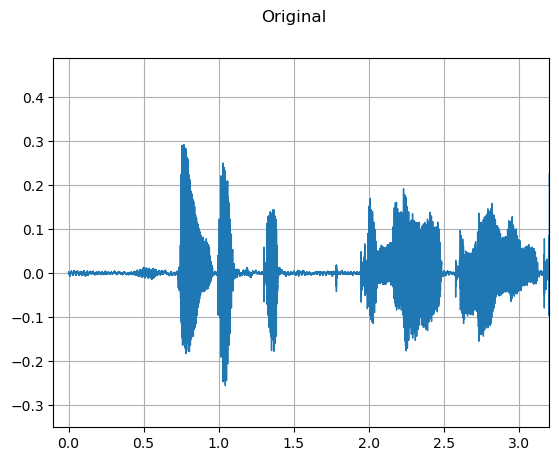

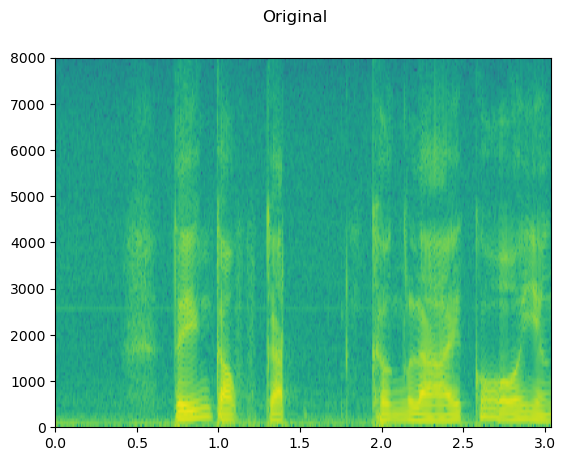

In [10]:
plot_waveform(waveform1.T, sample_rate, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1.T, sample_rate, title="Original", xlim=(0, 3.04))
Audio(waveform1.T, rate=sample_rate)

### Effects applied

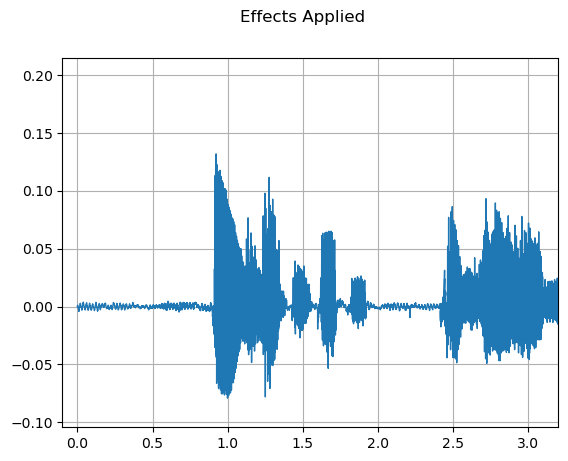

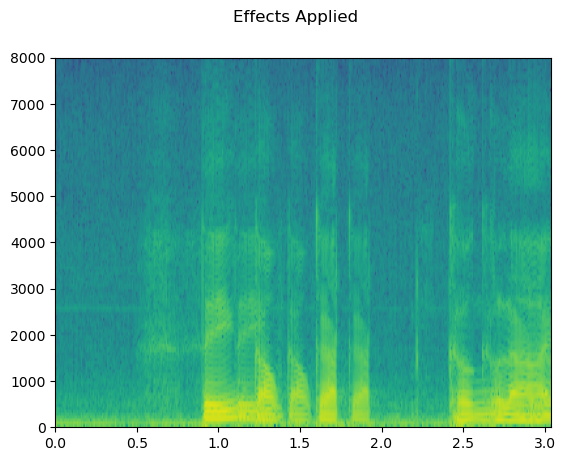

In [11]:
plot_waveform(waveform2.T, sample_rate, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2.T, sample_rate, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2.T, rate=sample_rate)

## Simulating room reverberation - Mô phỏng tiếng vang trong phòng

Reverb tích chập là một kỹ thuật được sử dụng để tạo ra âm thanh trong trẻo như thể nó được tạo ra trong một môi trường khác.

Ví dụ: bằng cách sử dụng Phản hồi xung trong phòng (RIR), chúng ta có thể tạo ra âm thanh giọng nói rõ ràng như thể nó được phát ra trong phòng hội thảo.

Đối với quá trình này, chúng tôi cần dữ liệu RIR. Dữ liệu sau đây được lấy từ tập dữ liệu VOiCES nhưng bạn có thể ghi âm dữ liệu của riêng mình - chỉ cần bật micrô và vỗ tay.

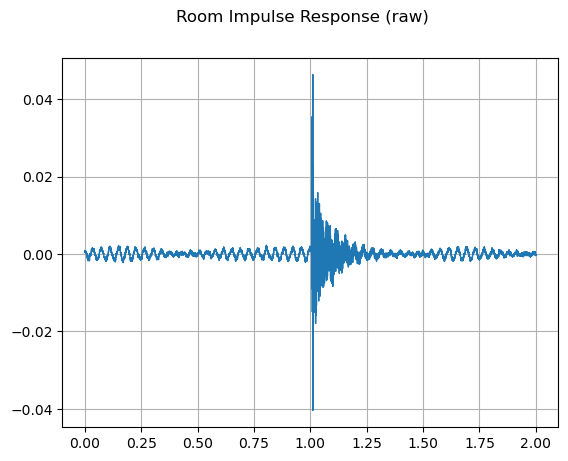

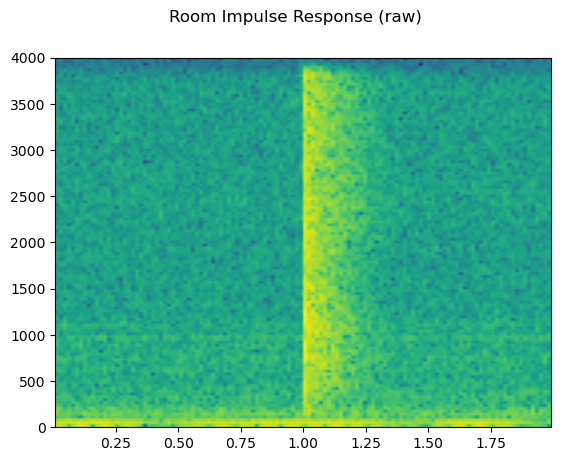

In [12]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

Đầu tiên, chúng ta cần dọn sạch RIR. Chúng tôi trích xuất xung lực chính và bình thường hóa nó bằng sức mạnh của nó.

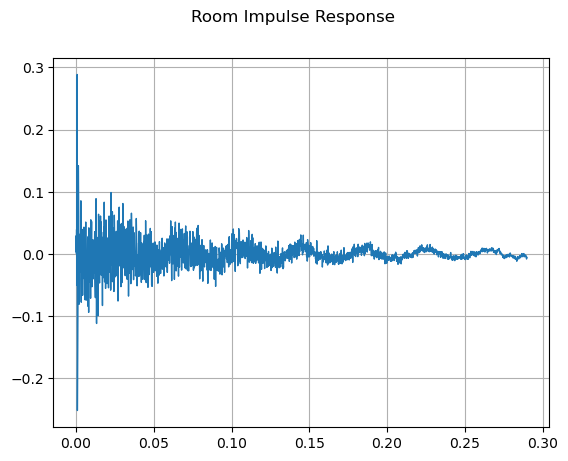

In [13]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

plot_waveform(rir, sample_rate, title="Room Impulse Response")

Sau đó, bằng cách sử dụng `torchaudio.functional.fftconvolve()`, chúng tôi kết hợp tín hiệu giọng nói với RIR.

In [14]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
augmented = F.fftconvolve(speech, rir)

### Original

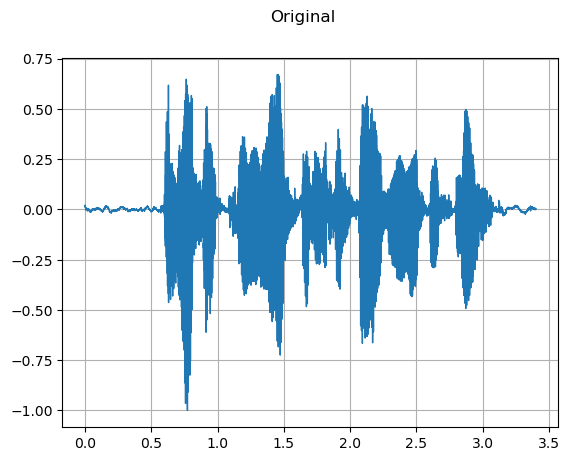

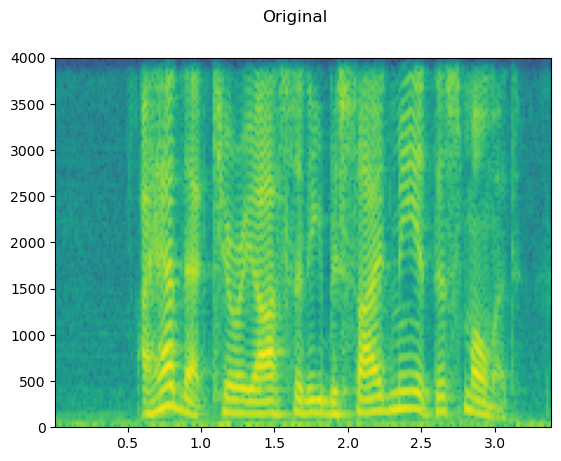

In [15]:
plot_waveform(speech, sample_rate, title="Original")
plot_specgram(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

### RIR applied


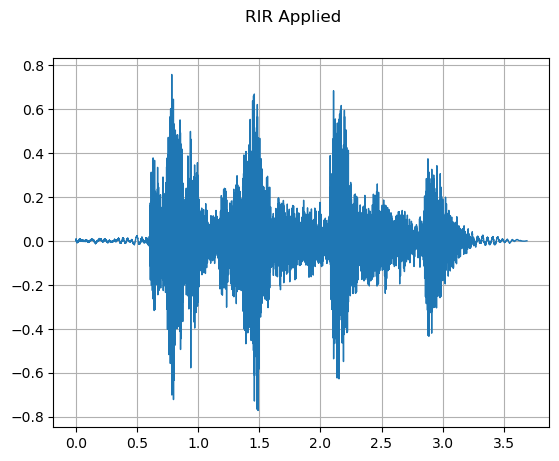

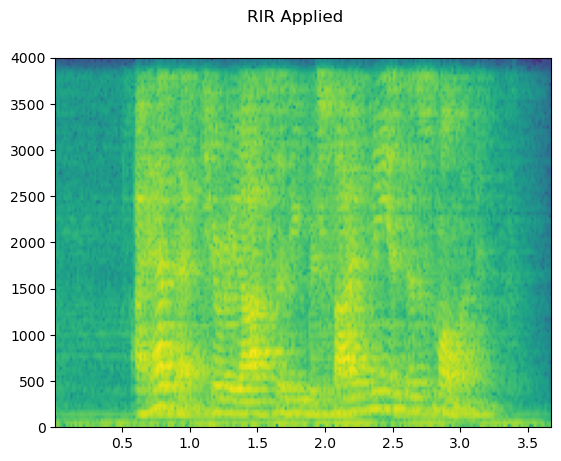

In [16]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

## Adding background noise

Để đưa nhiễu nền vào dữ liệu âm thanh, chúng ta có thể thêm Tensor nhiễu vào Tensor biểu thị dữ liệu âm thanh theo một số mong muốn 

Tỷ lệ tín hiệu trên nhiễu (SNR), xác định cường độ của dữ liệu âm thanh so với cường độ của nhiễu ở đầu ra.
 
​


In [17]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

snr_dbs = torch.tensor([20, 10, 3])
noisy_speeches = F.add_noise(speech, noise, snr_dbs)

### Background noise


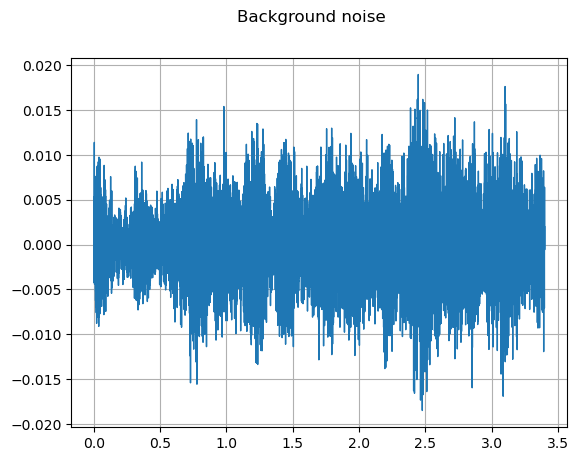

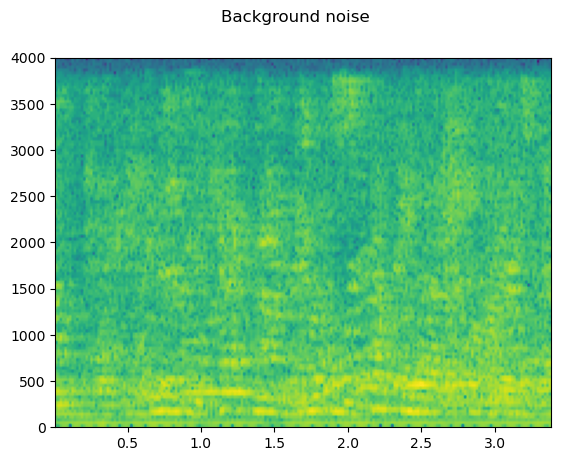

In [18]:
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)